In [1]:
import torch

from transformers import AutoTokenizer, BertModel

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import pytorch_lightning.callbacks as cb

from models.configurations import TEXT_PRETRAINED, VISION_PRETRAINED
from models.finetuner import AdaptorFinetuner
from models.adaptor import Adaptor
from utils.model_utils import get_newest_ckpt, StreamingProgressBar
from dataset.dataset import clf_collator
from dataset.configurations import DATASET_CFG
from dataset.data_module import AdaptorDataModule
from utils.args import get_train_parser
from utils.model_utils import load_vision_model

import numpy as np

In [2]:
vision_model = "dinov2-b"
text_model = "biobert"
# dataset = "rsna"
dataset = "siim"

vision_model_config = VISION_PRETRAINED[vision_model]
vision_pretrained = vision_model_config["pretrained_weight"]
vision_model_type = vision_model_config["vision_model_type"]

# dataset_cfg = DATASET_CFG["clf"][dataset]
dataset_cfg = DATASET_CFG["seg"][dataset]
dataset_class = dataset_cfg["class"]
dataset_kwargs = dataset_cfg["kwargs"]
data_transform = vision_model_config["data_transform"]

text_pretrained = TEXT_PRETRAINED[text_model]

In [3]:
adaptor_ckpt = get_newest_ckpt(
    vision_model, text_model, postfix="v2", 
    project_name="adaptor_pretrain_2_layers", 
)

adaptor = Adaptor.load_from_checkpoint(adaptor_ckpt)
backbone = load_vision_model(
    vision_model_type=vision_model_type,
    vision_pretrained=vision_pretrained,
    retain_head=False,
)


language_model = BertModel.from_pretrained(text_pretrained)
tokenizer = AutoTokenizer.from_pretrained(text_pretrained)

Using cache found in /homes/jq619/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [4]:
data_module = AdaptorDataModule(
    dataset=dataset_class,
    collate_fn=clf_collator,
    transforms=data_transform,
    data_pct=1.0,
    batch_size=4,
    num_workers=1,
    crop_size=224,
    seed=1117,
    **dataset_kwargs,
)
data_module.setup(stage="test")

# test_dataset = data_module.datasets['test']
loader = data_module.test_dataloader()

In [ ]:
from tqdm import tqdm
from math import ceil


n_samples = 400
total_steps = ceil(n_samples//data_module.batch_size)
i = 0

print(total_steps)

embeddings_list = []
labels_list = []
prediction_list = []

# Ensure no gradients are computed
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(loader), total=total_steps):
        if i == total_steps:
            break
        # Extract data from batch (depends on your data format)
        inputs, labels = batch['pixel_values'], batch['labels']
        # Move inputs to device (GPU if available)
        inputs = inputs.to(model.device)
        # Get embeddings
        pre_adaptor_embeddings = model.backbone(inputs)
        embeddings = model.adaptor(pre_adaptor_embeddings)
        pred = torch.argmax(linear_layer(embeddings), dim=1, keepdim=True).float()
        # Convert embeddings to numpy and store
        embeddings_list.append(embeddings.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        prediction_list.append(pred.cpu().numpy())
        
        i += 1

In [5]:
from tqdm import tqdm
from math import ceil

i = 0
total_steps = 1

# for batch_idx, batch in tqdm(enumerate(loader), total=total_steps):
for batch_idx, batch in enumerate(loader):
    if i == total_steps:
        break
    # Extract data from batch (depends on your data format)
    inputs, labels = batch['pixel_values'], batch['labels']
    inputs = inputs.to(adaptor.device)
    
    i += 1

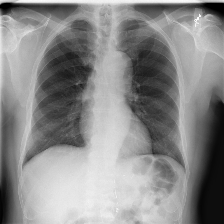

In [6]:
from PIL import Image

def pixel_values_to_image(pixel_values:torch.Tensor) -> Image.Image:
    array = ((0.5 * (pixel_values + 1.)) * 255).permute(1, 2, 0).numpy().astype(np.uint8)
    return Image.fromarray(array)

pixel_values_to_image(inputs[0])

In [7]:
batch_size = 4

lm_inputs = tokenizer.encode("pneumothorax positive", return_tensors="pt")
text_inputs = language_model(lm_inputs)["last_hidden_state"]
text_inputs = torch.concat([text_inputs.detach().cpu()] * batch_size, dim=0)

In [8]:
vision_inputs = backbone(inputs, is_training=True)["x_norm_patchtokens"]

In [9]:
adaptor_output = adaptor(vision_inputs[:, 0, :], text_inputs[:, 0, :])